In [1]:
import pandas as pd
import pickle as pkl
from collections import deque
import time
from brewer import BrewER, Table, SqlOrderBy
import brewer.resolution_function as resolution_function
import networkx as nx
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

In [2]:
# Change to raw dataset path
data = pd.read_csv("datasets/alaska_cameras_small/dataset.csv")

# Change to matches (dataframe with l_id and r_id pairs)
matches = pd.read_csv("datasets/alaska_cameras_small/matches.csv")

# Change to a pickled candidate pairs file (list of pairs)
with open(
    "datasets/alaska_cameras_small/blocking_functions/candidates_sparker.pkl",
    "rb",
) as f:
    candidates = pkl.load(f)

In [3]:
# If your matches aren't using l_id and r_id, or you have a different matching function change here
def matcher(l, r):
    return (
        ((matches["l_id"] == l) & (matches["r_id"] == r))
        | ((matches["l_id"] == r) & (matches["r_id"] == l))
    ).any()

In [4]:
# Change based on the query and resolution functions you specified on blender, for accurate comparison
def resolve(records):
    entity = {}
    entity["_id"] = records['_id'].mode()[0]
    entity["description"] = records['description'].mode()[0]
    entity["brand"] = records['brand'].mode()[0]
    entity["price"] = records["price"].min()
    entity["mp"] = records["mp"].mean()
    return entity

In [5]:
def match(candidate_pairs):
    seen = set()
    matches_set = set()
    not_matches_set = set()
    result = []
    comparisons = 0
    for idx, row in data.iterrows():
        # Change if your id column is different
        root = row["_id"]
        if root in seen:
            continue

        pairs = [pair for pair in candidate_pairs if root in pair]
        if pairs:
            block = set().union(*pairs)
        else:
            block = set((root,))

        entity_cluster = set([root])
        to_analyze = deque([root])

        while to_analyze:
            id = to_analyze.popleft()
            for candidate in block:
                if candidate in entity_cluster:
                    continue
                if id == candidate:
                    entity_cluster.add(candidate)
                    continue
                if (id, candidate) in matches_set:
                    entity_cluster.add(candidate)
                    to_analyze.append(candidate)
                    continue
                if (id, candidate) in not_matches_set:
                    continue
                comparisons += 1
                if matcher(id, candidate):
                    entity_cluster.add(candidate)
                    matches_set.add((id, candidate))
                    matches_set.add((candidate, id))
                    to_analyze.append(candidate)
                else:
                    not_matches_set.add((id, candidate))
                    not_matches_set.add((candidate, id))

        seen.update(entity_cluster)
        result.append((entity_cluster, comparisons))
    return result, comparisons


In [6]:
start = time.time()

results, batch_comparisons = match(candidates)

batch_elapsed_time = time.time() - start

In [7]:
# Change if your id column is different
resolved = pd.DataFrame([resolve(data[data["_id"].isin(entity[0])]) for entity in results])
# Change to the where query you used on blender, and the order by
batch_filtered = resolved[resolved["brand"] == "sony"].sort_values(
    "price", ascending=False
)
batch_filtered_entities = {tuple(sorted(results[index][0])) for index in batch_filtered.index}

In [8]:
[entity[1] for entity in results]

[26,
 34,
 83,
 103,
 152,
 208,
 237,
 250,
 267,
 512,
 523,
 544,
 5721,
 5829,
 5868,
 5869,
 5881,
 5903,
 5922,
 5937,
 5940,
 6020,
 6689,
 6700,
 6716,
 6733,
 6849,
 6867,
 6896,
 7058,
 7086,
 7112,
 7150,
 7165,
 7279,
 7349,
 7412,
 7543,
 7608,
 7788,
 7808,
 7830,
 7859,
 7943,
 7950,
 7996,
 7999,
 8037,
 8052,
 8113,
 8119,
 8158,
 8182,
 8188,
 8210,
 8340,
 8345,
 8464,
 8467,
 8490,
 8549,
 8569,
 8576,
 8595,
 8597,
 8612,
 8641,
 8679,
 8710,
 8714,
 8714,
 8790,
 8799,
 8921,
 8938,
 9039,
 9057,
 9057,
 9100,
 9118,
 9124,
 9151,
 9176,
 9181,
 9188,
 9192,
 9195,
 9233,
 9290,
 9309,
 9496,
 9561,
 9577,
 9582,
 9585,
 9592,
 9634,
 9935,
 9960,
 9967,
 10038,
 10087,
 10124,
 10125,
 10201,
 10315,
 10372,
 10529,
 10569,
 10642,
 10672,
 10691,
 10780,
 10789,
 10882,
 10906,
 10934,
 10959,
 11156,
 11156,
 11200,
 11236,
 11309,
 11384,
 11415,
 11470,
 11501,
 11536,
 11582,
 11609,
 11609,
 11609,
 11706,
 11706,
 11720,
 11723,
 11723,
 11741,
 11741,
 11

In [9]:
print("Batch comparisons:", batch_comparisons)
print("Batch elapsed time:", batch_elapsed_time)
print("Batch emitted:", len(batch_filtered))
pd.DataFrame(
    [
        {"comparisons": 0, "recall": 0, "precision": 0, "f1": 0, "correctness": 0},
        {"comparisons": batch_comparisons - 1, "recall": 0, "precision": 0, "f1": 0, "correctness": 0},
        {"comparisons": batch_comparisons, "recall": 1, "precision": 1, "f1": 1, "correctness": 1}
    ]
).to_csv('output/batch_results.csv')

Batch comparisons: 22073
Batch elapsed time: 63.141042709350586
Batch emitted: 211


In [10]:
# Change based on you matches file
def matcher_table(l, r):
      return (
        ((matches["l_id"] == l["table__id"]) & (matches["r_id"] == r["table__id"]))
        | ((matches["l_id"] == r["table__id"]) & (matches["r_id"] == l["table__id"]))
    ).any()

In [11]:
brewer_start = 0
brewer_results = []
def listener(entity, cluster, comparisons):
    global brewer_start       

    cluster_set = {tuple(sorted(cluster))}

    # Change based on the attribute you used to sort
    brewer_results.append({
        "elapsed_time": time.time() - brewer_start,
        "comparisons": comparisons,
        "order": entity["table_price"],
        "tp": len(cluster_set & batch_filtered_entities),
        "fp": len(cluster_set - batch_filtered_entities),
    })

In [12]:
# Create evaluation dataframe
def evaluate_results(mode):
    brewer_dataframe = pd.DataFrame(brewer_results)

    if len(brewer_dataframe) > 0:
        prev = brewer_dataframe["order"].shift(1)
        # CHANGE < TO > IF ASC
        brewer_dataframe["correct_order"] = brewer_dataframe["order"].isna() |  (brewer_dataframe["order"] > prev) | np.isclose(brewer_dataframe["order"], prev, 1e-8)
        brewer_dataframe.loc[0, "correct_order"] = True

        brewer_dataframe["running_tp"] = brewer_dataframe["tp"].cumsum()
        brewer_dataframe["running_fp"] = brewer_dataframe["fp"].cumsum()
        brewer_dataframe["running_fn"] = (
            len(batch_filtered_entities) - brewer_dataframe["running_tp"]
        )
        brewer_dataframe["running_correctness"] = brewer_dataframe[
            "correct_order"
        ].cumsum()

        brewer_dataframe["recall"] = (
            brewer_dataframe["running_tp"]
            / (brewer_dataframe["running_tp"] + brewer_dataframe["running_fn"])
        ).replace(np.nan, 0)
        brewer_dataframe["precision"] = (
            brewer_dataframe["running_tp"]
            / (brewer_dataframe["running_tp"] + brewer_dataframe["running_fp"])
        ).replace(np.nan, 0)
        brewer_dataframe["correctness"] = brewer_dataframe["running_correctness"] / (
            brewer_dataframe.index + 1
        )
        brewer_dataframe["f1"] = (
            2
            * (brewer_dataframe["precision"] * brewer_dataframe["recall"])
            / (brewer_dataframe["precision"] + brewer_dataframe["recall"])
        )

        brewer_dataframe.to_csv(f"output/brewer_{mode}_results.csv", index=False)
    else:
        print("No results from brewer to evaluate.")

In [13]:
G = nx.Graph()
G.add_edges_from(candidates)
blocks = [list(set(x)) for x in nx.connected_components(G)]

In [22]:
# Configure
brewer = (BrewER()
    .from_table(Table(data, blocks, matcher_table, "table", "_id"))
    .select(
        ("table._id", resolution_function.VOTE),
        ("table.description", resolution_function.VOTE),
        ("table.brand", resolution_function.VOTE),
        ("table.price", resolution_function.AVG),
        ("table.mp", resolution_function.AVG),
        order_by=("table.mp", SqlOrderBy.ASC),
    )
    .where('table.brand = "sony"')
    .subscribe(listener)
)

In [23]:
brewer_start = time.time()
brewer_results = []
comparisons = 0
brewer.run(seeds_only=False, reset_matches=True)
evaluate_results("normal")

In [24]:
brewer_start = time.time()
brewer_results = []
comparisons = 0
brewer.run(seeds_only=True, reset_matches=True)
evaluate_results("seed")

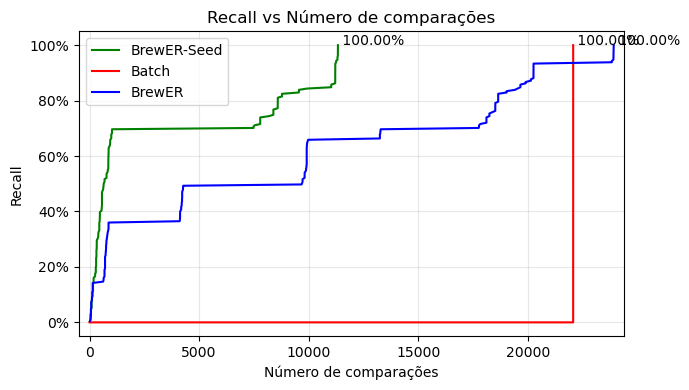

Salvo: output\recall_vs_comparisons.png


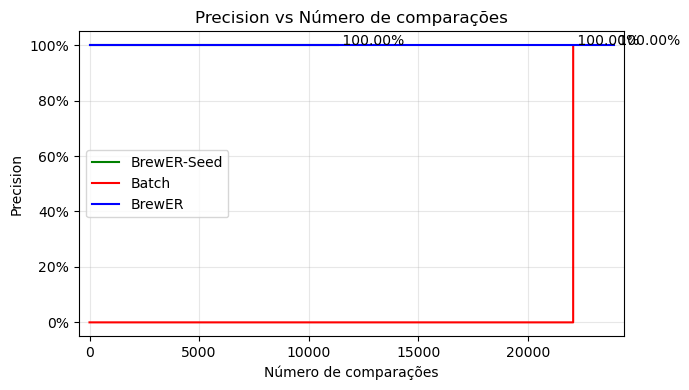

Salvo: output\precision_vs_comparisons.png


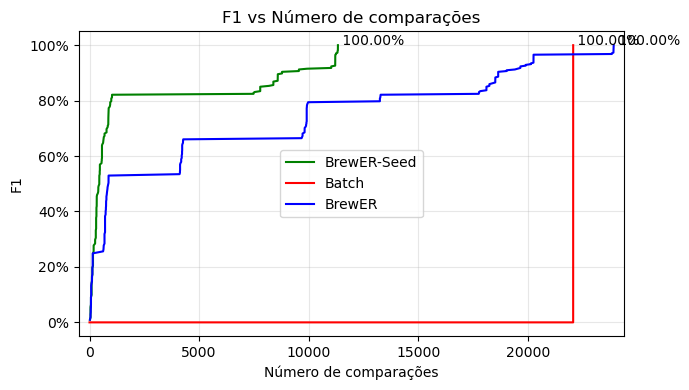

Salvo: output\f1_vs_comparisons.png


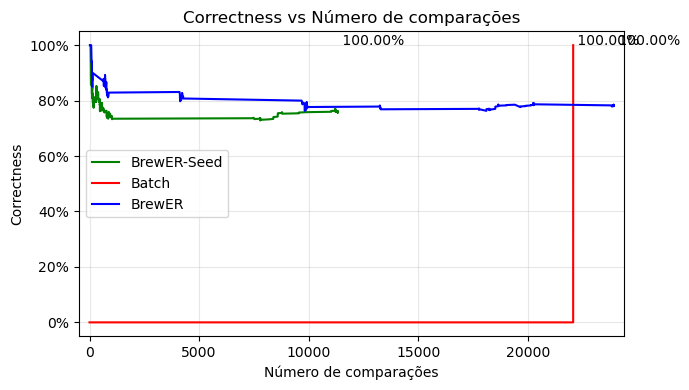

Salvo: output\correctness_vs_comparisons.png


In [25]:
brewer_normal = pd.read_csv("output/brewer_normal_results.csv")
brewer_seed = pd.read_csv("output/brewer_seed_results.csv")
batch = pd.read_csv("output/batch_results.csv")

metrics = ["recall", "precision", "f1", "correctness"]
comparisons_col = "comparisons"

out_dir = Path("output")
out_dir.mkdir(parents=True, exist_ok=True)

batch_max_comp = batch[comparisons_col].max()
brewer_normal_max_comp = brewer_normal[comparisons_col].max()
brewer_seed_max_comp = brewer_seed[comparisons_col].max()
maximum = max(batch_max_comp, brewer_normal_max_comp, brewer_seed_max_comp)
xlim = maximum / 50

for m in metrics:
    plt.figure(figsize=(7, 4))

    plt.plot(brewer_seed[comparisons_col], brewer_seed[m], label="BrewER-Seed", color="green")
    plt.annotate(
        f"{brewer_seed[m].max() * 100 : 0.2f}%",
        xy=(
            int(brewer_seed.iloc[int(brewer_seed[comparisons_col].idxmax())][comparisons_col]),
            brewer_seed[m].max(),
        ),
        xycoords="data",
    )

    plt.plot(batch[comparisons_col], batch[m], label="Batch", color="red")
    plt.annotate(
        f"{batch[m].max() * 100 : 0.2f}%",
        xy=(
            int(batch.iloc[int(batch[comparisons_col].idxmax())][comparisons_col]),
            batch[m].max(),
        ),
        xycoords="data",
    )

    plt.plot(brewer_normal[comparisons_col], brewer_normal[m], label="BrewER", color="blue")
    plt.annotate(
        f"{brewer_normal[m].max() * 100 : 0.2f}%",
        xy=(
            int(brewer_normal.iloc[int(brewer_normal[comparisons_col].idxmax())][comparisons_col]),
            brewer_normal[m].max(),
        ),
        xycoords="data",
    )

    plt.xlabel("Número de comparações")
    plt.ylabel(m.capitalize())
    plt.title(f"{m.capitalize()} vs Número de comparações")
    plt.grid(True, alpha=0.3)
    plt.xlim([0 - xlim, maximum + xlim])
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="best")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    png_path = out_dir / f"{m}_vs_comparisons.png"
    plt.tight_layout()
    plt.savefig(png_path, dpi=150)
    plt.show()
    print(f"Salvo: {png_path}")